# Flat Unrolled Cascade - Single-channel - Train

- Single-channel data
- Images are 256x256
- R=5 

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
import nibabel as nib

# Importing our model
MY_UTILS_PATH = "../src/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_sc as fsnet
import tensorflow as tf
# Importing callbacks and data augmentation utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
## PARAMETERS
H,W = 256,256 # Training image dimensions
channels = 2 # complex data 0-> real; 1-> imaginary
norm = np.sqrt(H*W)

#All data
data_path = "/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/*.nii.gz"
all_files = np.asarray(glob.glob(data_path))

# Train Set 

rec_files_train = all_files[:5]

rec_files_val = all_files[6:9]

indexes = np.arange(rec_files_train.size,dtype = int)
np.random.shuffle(indexes)
rec_files_train = rec_files_train[indexes]

print(rec_files_train)
print(rec_files_val)

['/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/TUM57_20200625_132349_ax_fspgr_3d_post.nii.gz'
 '/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/TUMPER_006_20140102_103415_ax_fspgr_bravo_pre.nii.gz'
 '/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/TUM33_20180828_120250_ax_fspgr_bravo_pre.nii.gz'
 '/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/TUM26_20180508_101545_ax_fspgr_3d_post.nii.gz'
 '/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/TUM21_20170925_143218_ax_fspgr_3d_post.nii.gz']
['/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/TUM39_20190402_114720_ax_fspgr_3d_post.nii.gz'
 '/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructed/TUM04_20180103_120056_ax_fspgr_3d_post.nii.gz.nii.gz'
 '/home/youssef/Desktop/brain-cancer-longitudinal-study/data/TumPer/reconstructe

In [4]:
# Get number of training samples
ntrain = 0
for ii in range(len(rec_files_train)):
    rec = nib.load(rec_files_train[ii])
    if rec.shape[0] == W:
        aux = rec.shape[-1]
    else:
        aux = rec.shape[0]
    print(aux, rec.shape)
    ntrain += aux 
print('number of training sample', ntrain)

152 (256, 256, 152)
144 (256, 256, 144)
170 (256, 256, 170)
156 (256, 256, 156)
160 (256, 256, 160)
number of training sample 782


In [5]:

# Load train data    
rec_train = np.zeros((ntrain,H,W,2))
kspace_train = np.zeros((ntrain,H,W,2))
aux_counter = 0
for ii in range(len(rec_files_train)):
    aux_rec = nib.load(rec_files_train[ii]).get_fdata()
    aux_rec = aux_rec / np.abs(aux_rec).max()
    aux_shape = aux_rec.shape
    if aux_shape[0] == W:
        aux_rec = np.swapaxes(aux_rec, 0,2)
        aux = aux_rec.shape[0]
    else:
        aux = aux_rec.shape[0]
    
    #convert reconstructed data to kspace 
    f = np.fft.fft2(aux_rec)

    #convert kspace back to image domain to get complex reconsturction
    aux2_rec = np.zeros((aux_rec.shape[0],aux_rec.shape[1],aux_rec.shape[2],2))
    rec = np.fft.ifft2(f)
    #compile all training data
    rec_train[aux_counter:aux_counter+aux,:,:,0] = rec.real  
    rec_train[aux_counter:aux_counter+aux,:,:,1] = rec.imag 
    kspace_train[aux_counter:aux_counter+aux,:,:,0] = f.real 
    kspace_train[aux_counter:aux_counter+aux,:,:,1] = f.imag
    aux_counter += aux


# Shuffle training    
#indexes = np.arange(rec_train.shape[0],dtype = int)
##np.random.shuffle(indexes)
#rec_train = rec_train[indexes]
#print("Number of training samples", rec_train.shape[0])

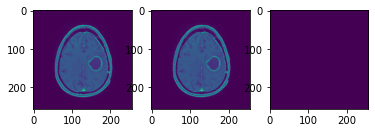

In [6]:
ift = np.fft.ifftshift(kspace_train[100,:,:,0]+1j*kspace_train[100,:,:,1])
img_back = np.abs(np.fft.ifft2(ift))
img = np.abs(rec_train[100,:,:,0]+1j*rec_train[100,:,:,1])
plt.figure()
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(img_back)
plt.subplot(133)
plt.imshow(np.abs(img - img_back))

In [7]:
img_back.max()

0.7219791316055201

In [8]:
img.max()

0.7219791316055201

In [9]:
# Get number of validation samples
nval = 0
for ii in range(len(rec_files_val)):
    rec = nib.load(rec_files_val[ii])
    if rec.shape[0] == W:
        aux = rec.shape[-1]
    else:
        aux = rec.shape[0]
    print(aux, rec.shape)
    nval += aux 
print('number of validation samples', nval)

160 (256, 256, 160)
148 (148, 256, 256)
140 (140, 256, 256)
number of validation samples 448


In [10]:
# Load valiadtion data    
kspace_val = np.zeros((nval,H,W,2))
rec_val = np.zeros((nval,H,W,2))

aux_counter = 0
for ii in range(len(rec_files_val)):
    aux_rec = nib.load(rec_files_val[ii]).get_fdata()
    aux_rec = aux_rec / aux_rec.max()
    aux_shape = aux_rec.shape
    if aux_shape[0] == W:
        aux_rec = np.swapaxes(aux_rec, 0,2)
        aux = aux_rec.shape[0]
    else:
        aux = aux_rec.shape[0]
    
    #convert reconstructed data to kspace 
    f = np.fft.fft2(aux_rec)
    #fshift = np.fft.fftshift(f)
    aux_kspace = np.zeros((aux_rec.shape[0],aux_rec.shape[1],aux_rec.shape[2],2))
    aux_kspace[:,:,:,0] = f.real
    aux_kspace[:,:,:,1] = f.imag
    #convert kspace back to image domain to get complex reconsturction
    aux2_rec = np.zeros((aux_rec.shape[0],aux_rec.shape[1],aux_rec.shape[2],2))
    rec = np.fft.ifft2(f)
    #compile all training data
    rec_val[aux_counter:aux_counter+aux,:,:,0] = rec.real 
    rec_val[aux_counter:aux_counter+aux,:,:,1] = rec.imag 
    kspace_val[aux_counter:aux_counter+aux,:,:,0] = f.real 
    kspace_val[aux_counter:aux_counter+aux,:,:,1] = f.imag

    aux_counter += aux




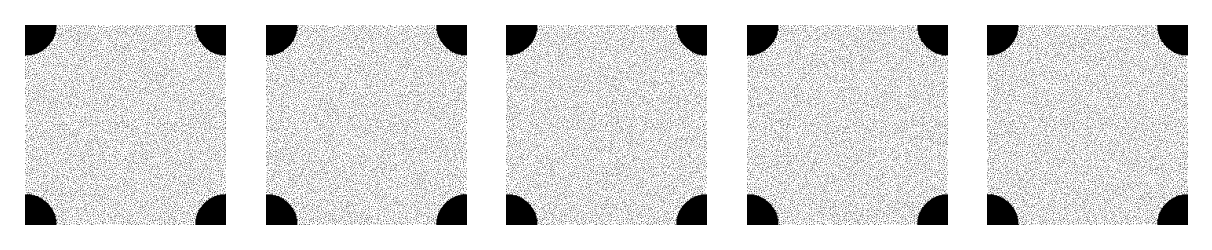

Undersampling: 0.8004342651367188


In [11]:
# Loading sampling patterns. Notice that here we are using uncentred k-space
var_sampling_mask = np.fft.fftshift(~np.load("../data/sampling_masks/R5_256x256_poisson_center_true_radius_40.npy"),axes=(1,2))
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                               
                                   axis = -1)


# White pixels are retrospectively discarded
plt.figure(dpi = 250)
for ii in range(5):
    plt.subplot(1,5,ii+1)
    plt.imshow(var_sampling_mask[ii*10,:,:,0],cmap = "gray")
    plt.axis("off")
plt.show()

print("Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)

In [12]:
epochs = 100
batch_size= 6

model_name = "../models/flat_unrolled_cascade_ikikii.hdf5"

# Early stopping callback to shut down training after
# 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)

0.04047909275928516
0.05265548


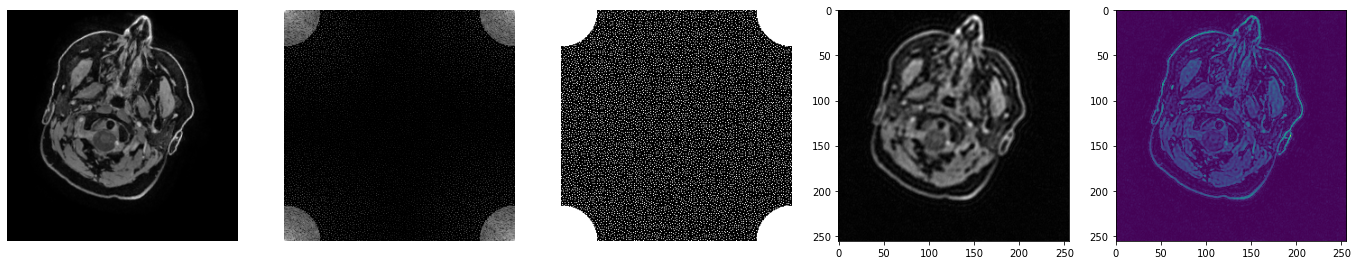

0.057664149722962785
0.075246036


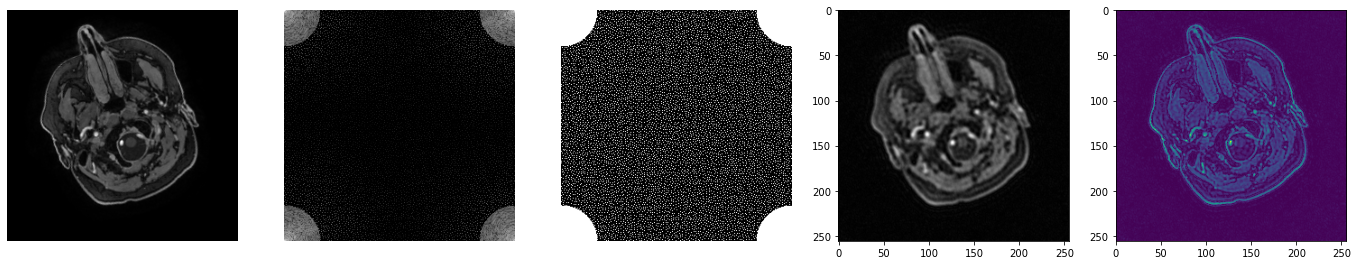

0.07024889928907407
0.09280028


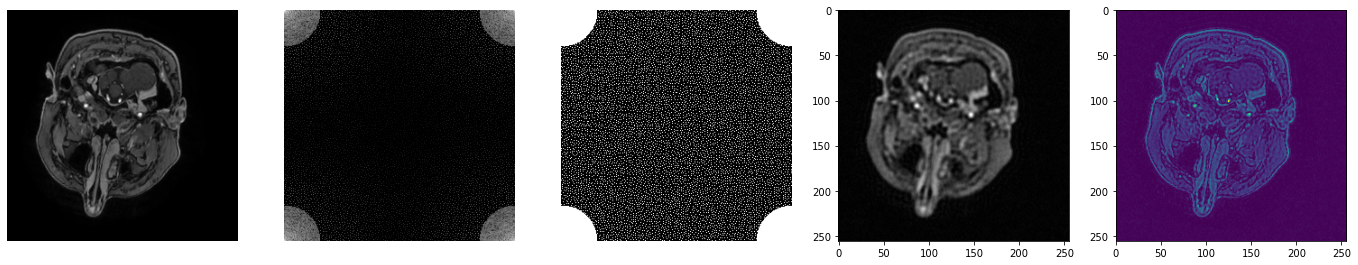

0.07806349226839465
0.10371435


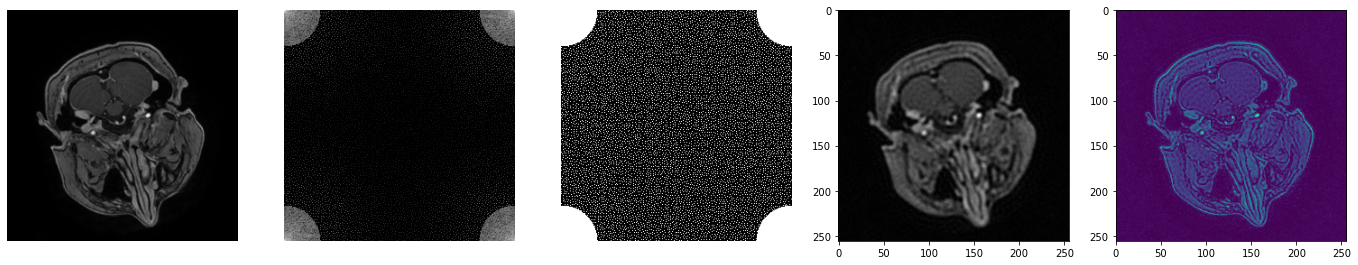

0.07169566316813461
0.09359383


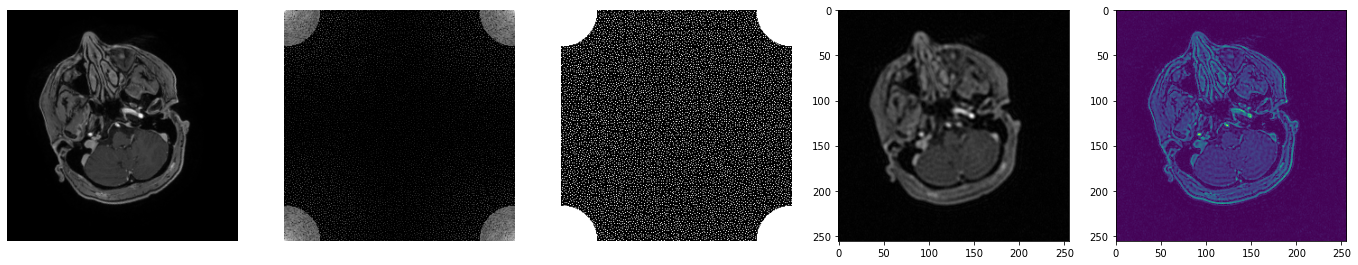

0.07015872558172712
0.09169251


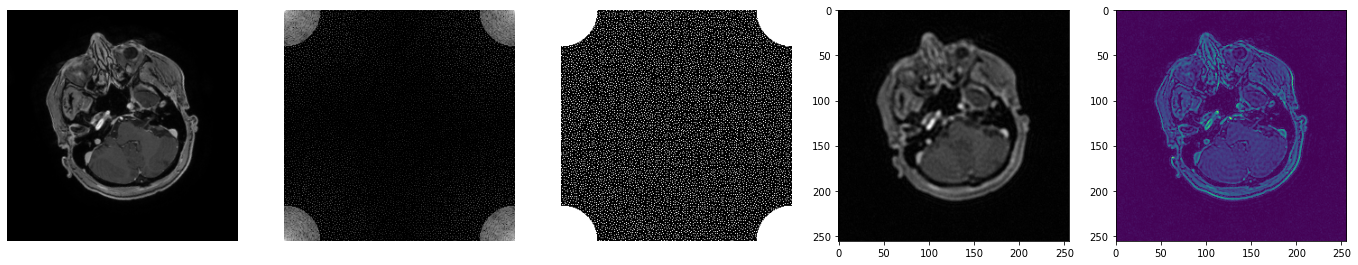

0.06977145492990894
0.090482295


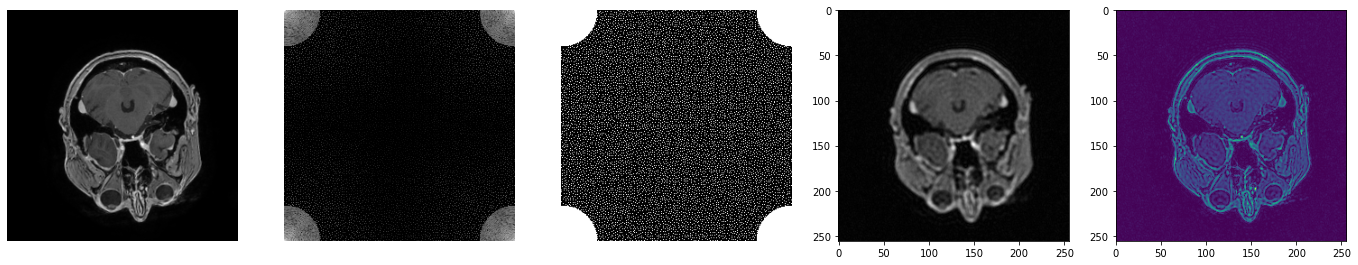

In [13]:
# On the fly data augmentation
def combine_generator(gen1,gen2,under_masks):
    while True:
        rec_real = gen1.next()
        rec_imag = gen2.next()
        f = np.fft.fft2(rec_real[:,:,:,0]+1j*rec_imag[:,:,:,0])
        #kspace = np.fft.ifftshift(f)
        kspace2 = np.zeros((f.shape[0],f.shape[1],f.shape[2],2))
        kspace2[:,:,:,0] = f.real
        kspace2[:,:,:,1] = f.imag
        indexes = np.random.choice(np.arange(under_masks.shape[0], dtype=int), rec_real.shape[0], replace=False)
        kspace2[under_masks[indexes]] = 0
        
        rec_complex = np.zeros((rec_real.shape[0],rec_real.shape[1],rec_real.shape[2],2),dtype = np.float32)
        rec_complex[:,:,:,0] = rec_real[:,:,:,0]
        rec_complex[:,:,:,1] = rec_imag[:,:,:,0]
        
        yield([kspace2,under_masks[indexes].astype(np.float32)],[rec_complex])
        
seed = 905
image_datagen1 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

image_datagen2 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')


image_generator1 = image_datagen1.flow(rec_train[:,:,:,0,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)
image_generator2 = image_datagen2.flow(rec_train[:,:,:,1,np.newaxis],batch_size = batch_size,seed = seed, shuffle=False)        


combined = combine_generator(image_generator1,image_generator2, var_sampling_mask)

# Dispaly sample data augmentation
counter = 0
for ii in combined:
    
    fback = np.fft.ifft2(ii[0][0][4,:,:,0]+1j*ii[0][0][4,:,:,1])
    img = np.abs(ii[1][0][4,:,:,0]+1j*ii[1][0][4,:,:,0])
    print(np.abs(fback).mean())
    print(img.mean())
    plt.figure(figsize=(24,10))
    plt.subplot(151)
    plt.imshow(img,cmap = 'gray')
    plt.axis("off")
    plt.subplot(152)
    plt.imshow(np.log(1+np.abs(ii[0][0][4,:,:,0] + 1j*ii[0][0][4,:,:,1])),cmap = 'gray')
    plt.axis("off")
    plt.subplot(153)
    plt.imshow(ii[0][0][4,:,:,0].astype(bool),cmap = 'gray')
    plt.axis("off")
    plt.subplot(154)
    plt.imshow(np.abs(fback), cmap='gray')
    plt.subplot(155)
    plt.imshow(np.abs(np.abs(fback)-img))
    plt.show()
    counter+=1
    if counter > 6:
        break

In [14]:
# Undersampling the validation set
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),kspace_val.shape[0],replace = True)
val_var_sampling_mask = (var_sampling_mask[indexes])
kspace_val[val_var_sampling_mask] = 0






In [16]:
# Training our model
model = fsnet.deep_cascade_flat_unrolled("ikikii", H, W,channels=2)
opt = Adam(lr = 1e-3,decay = 1e-2)
model.compile(loss = 'mse',optimizer=opt)
print(model.summary())

hist = model.fit(combined,
             epochs=epochs,
             steps_per_epoch=rec_train.shape[0]//batch_size,
             verbose=1,
             validation_data= ([kspace_val,val_var_sampling_mask],[rec_val]),
             callbacks=[checkpoint,earlyStopping])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 256, 256, 2)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 256, 256, 48) 912         lambda_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_30 (LeakyReLU)      (None, 256, 256, 48) 0           conv2d_36[0][0]                  
____________________________________________________________________________________________

 35/130 [=======>......................] - ETA: 11s - loss: nan

KeyboardInterrupt: 

In [118]:
img_back = np.abs(np.fft.ifft2(kspace_val[0,:,:,0]+1j*kspace_val[0,:,:,1]))
img = np.abs(rec_val[0,:,:,0]+1j*rec_val[0,:,:,1])

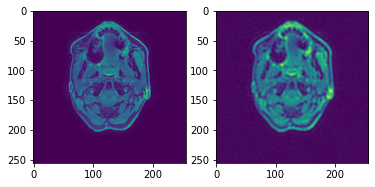

In [119]:
plt.figure()
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_back)